# Unscented  kalman filter to estimate and predict next state 


In [7]:
'''
Simulating the equation $mL^2\ddot{\theta} + b \dot{\theta} +mgL sin(\theta) = 0$
'''
# this cell is to implement UKF with kappa =4

import numpy as np
import cv2
import time

from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import JulierSigmaPoints
import matplotlib.pyplot as plt


# visulaization parameters
height = 600
width = 600

# simulation 
center = None

# Pendulum parameters and variables

#    initial conditions
theta = np.pi/4 # the angle 
omega = 0           # the angular velocity 

#    parametrs
g = 9.8 # m/s^2
L = .2 # m
m = 0.05 # kg
b = 0.001  # friction constant 

# Numerical integration parameters
framerate = 60.0 # in frames per second
dt = 1.0/framerate # Set dt to match the framerate of the webcam or animation
t = time.clock()

# Drawing parametres
thickness = 3

# Noise parameters 
Sigma = 30*np.array([[1, 0],[0,1]])

#Kalman inferred state variables
theta_kf = theta
omega_kf = omega
#theta_kf_old = theta_kf
#Keep looping

# Create background image
frame = np.zeros((height,width,3), np.uint8)

center_old = (300, 300)
center_noisy_old = (300, 300)
center_kf_old = (300, 300)


L_kf= 200
# Create background image
frame = np.zeros((height,width,3), np.uint8)

cv2.circle(frame, (300, 300), 10, (0, 255, 255), -1)  

##################
# ukf functions  #
##################
#function to return the nonlinear state transition variables (theta, omega)
def fx(X,dt):
    
    theta=X[0]
    omega=X[1]
    
    theta= theta+ omega*dt
    omega = omega - dt*g/L_kf*np.sin(theta) - dt*b/(m*L_kf*L_kf)*omega
    
    return np.c_[theta,omega]

# The update step converts the sigmas into measurement space via the h(x) function return theta and omega
def hx(X):

    return X 

#points = MerweScaledSigmaPoints(n, alpha=.1, beta=2., kappa=-1)
points = MerweScaledSigmaPoints(2, alpha=1e-3, beta=2., kappa=6)
#points = JulierSigmaPoints(n=2, kappa=1)


kf = UKF(dim_x=2, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)
kf.x = np.array([theta_kf ,omega_kf]) # initial state

kf.R = Sigma # a measurement noise matrix  
kf.Q = np.diag([4.5,4.5])   # process noise the smae shape as the state variables 2X2  

######################
# end ukf functions  #
######################
readings_noisy= []
readings_after_ukf=[]
theta_theoritical=[]
while True:
    cv2.circle(frame, (300, 300), 10, (0, 255, 255), -1)   
# == Simulation model ==

    # Update state 
    theta = theta + dt*omega
    theta_theoritical.append(theta)
    omega = omega - dt*g/L*np.sin(theta) - dt*b/(m*L*L)*omega 

    # Map the state to a nearby pixel location
    center = np.array((int(300+ 200*np.sin(theta)) ,int(300 + 200*np.cos( theta))) ) 
   
    center_noisy = tuple(center+np.matmul(Sigma,np.random.randn(2)).astype(int))

    # Draw the pendulum
   
    cv2.circle(frame, tuple(center_old), 10, (0, 0, 0), -1)              
    cv2.circle(frame, center_noisy_old, 10, (0, 0, 0), -1)


    cv2.circle(frame, tuple(center), 10, (0, 255, 255), -1)                
    cv2.circle(frame, center_noisy, 10, (0, 0, 255), -1)                  

    center_old = center
    center_noisy_old = center_noisy


####################################################################
#### here starts  the unscented kalman filter implementation       #
####################################################################
    center_noisy_kf=center_noisy
    readings_noisy.append(np.arctan( (center_noisy_kf[0]-300)/(center_noisy_kf[1]-300)))
    print('theoritical theta and omega',theta,omega)
    #unscented kalman filter pridection 
    kf.predict()
    #print('predicted theta and omega',kf.x[0],kf.x[1])
    
    theta_kf=kf.x[0]
    omega_kf=kf.x[1]
    print('predicted theta and omega',theta_kf,omega_kf)
    
    #center noisy kf update   
    # unscented kalman filter updating the state variables 
    kf.update([ (np.arctan( (center_noisy_kf[0]-300)/(center_noisy_kf[1]-300))),0])
    
    #print("after updtae",theta_kf)
    #maping the updated theta to the nearest pixels 
    center_kf = np.array((int(300+ L_kf*np.sin(kf.x[0])) ,int(300 + L_kf*np.cos(kf.x[0]))) )
    readings_after_ukf.append(np.arctan( (center_kf[0]-300)/(center_kf[1]-300)))

    ####################################################################
    #### here finishes the unscented kalman filter implementation      #
    ####################################################################

    # Map the state to a nearby pixel location
    
    cv2.circle(frame, tuple(center_kf_old), 10, (0, 0, 0), -1)
    center_kf_old = center_kf
    cv2.circle(frame, tuple(center_kf), 10, (255, 0, 255), -1)

    # show the frame to our screen
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(int(dt*400)) & 0xFF

    #if the 'Esc' key is pressed, stop the loop
    if key == 27:
        break


# Wait with calculating next animation step to match the intended framerate
t_ready = time.clock()
d_t_animation = t + dt -  t_ready
t += dt
if  d_t_animation > 0:
    time.sleep(d_t_animation)






# close all windows
cv2.destroyAllWindows()



C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


theoritical theta and omega 0.7853981633974483 -0.5774705379690138
predicted theta and omega 0.7853981634034426 -0.00028865525720789265
theoritical theta and omega 0.7757736544312981 -1.1445442912093784
predicted theta and omega 0.7868208122963551 0.0007461995560333889
theoritical theta and omega 0.7566979162444751 -1.6956678719863245
predicted theta and omega 0.8029377557977568 0.00298260017893881
theoritical theta and omega 0.7284367850447031 -2.225195534598921
predicted theta and omega 0.7577629702936974 0.004118029147321067
theoritical theta and omega 0.6913501928013878 -2.7273408833628894
predicted theta and omega 0.7283119847779744 0.005337138754384796
theoritical theta and omega 0.6458945114120063 -3.1961753274347235
predicted theta and omega 0.8083318603603402 0.00875100880273294
theoritical theta and omega 0.5926249226214275 -3.625681744286737
predicted theta and omega 0.7724374106765026 0.008673472423083695
theoritical theta and omega 0.5321968935499819 -4.009866948692588
pre

theoritical theta and omega -0.4064646841189305 -2.4363014078008036
predicted theta and omega -0.15408258248316997 -0.0038455137977280174
theoritical theta and omega -0.4470697075822772 -2.062933400078363
predicted theta and omega -0.2132084493405273 -0.0048489847009705045
theoritical theta and omega -0.48145193091691657 -1.667571277721494
predicted theta and omega -0.18612963736268284 -0.003670715022508375
theoritical theta and omega -0.5092447855456081 -1.2555351516625841
predicted theta and omega -0.3108705595586798 -0.006513630073072818
theoritical theta and omega -0.5301703714066512 -0.8321000879895063
predicted theta and omega -0.39144562877481803 -0.007936846317988966
theoritical theta and omega -0.5440387062064763 -0.40246266551325743
predicted theta and omega -0.4790941333885712 -0.009442140847340852
theoritical theta and omega -0.5507464172983639 0.028271984925277886
predicted theta and omega -0.5303023274973384 -0.009956590209640126
theoritical theta and omega -0.55027521754

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:173: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


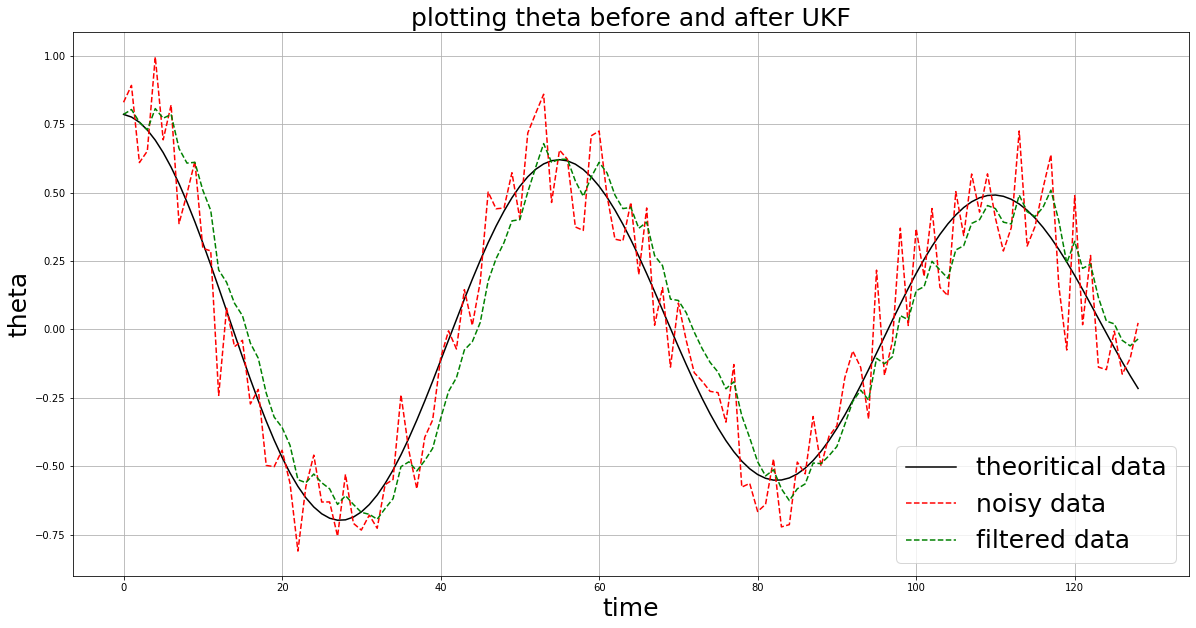

In [8]:
### plotting the behavior of ukf 
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(theta_theoritical,'black',label="theoritical data")
plt.plot(readings_noisy, 'r--',label='noisy data')
plt.plot(readings_after_ukf, 'g--', label="filtered data")
plt.title('plotting theta before and after UKF',fontsize=25)
plt.xlabel('time',fontsize=25)
plt.ylabel('theta',fontsize=25)
plt.legend(fontsize=25)
plt.grid(True)
plt.show()

###this figure is with friction .but without it it will continue it's oscilation 

In [9]:
'''
Simulating the equation $mL^2\ddot{\theta} + b \dot{\theta} +mgL sin(\theta) = 0$
'''
# this cell is to implement UKF with kappa =1

import numpy as np
import cv2
import time

from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import JulierSigmaPoints
import matplotlib.pyplot as plt


# visulaization parameters
height = 600
width = 600

# simulation 
center = None

# Pendulum parameters and variables

#    initial conditions
theta = np.pi/4 # the angle 
omega = 0           # the angular velocity 

#    parametrs
g = 9.8 # m/s^2
L = .2 # m
m = 0.05 # kg
b = 0.001  # friction constant 

# Numerical integration parameters
framerate = 60.0 # in frames per second
dt = 1.0/framerate # Set dt to match the framerate of the webcam or animation
t = time.clock()

# Drawing parametres
thickness = 3

# Noise parameters 
Sigma = 30*np.array([[1, 0],[0,1]])

#Kalman inferred state variables
theta_kf = theta
omega_kf = omega


# Create background image
frame = np.zeros((height,width,3), np.uint8)

center_old = (300, 300)
center_noisy_old = (300, 300)
center_kf_old = (300, 300)


L_kf= 200
# Create background image
frame = np.zeros((height,width,3), np.uint8)

cv2.circle(frame, (300, 300), 10, (0, 255, 255), -1)  

##################
# ukf functions  #
##################
#function to return the nonlinear state transition vatiables (theta, omega)
def fx(X,dt):
    
    theta=X[0]
    omega=X[1]
    
    theta= theta+ omega*dt
    omega = omega - dt*g/L_kf*np.sin(theta) - dt*b/(m*L_kf*L_kf)*omega
    
    return np.c_[theta,omega]


# The update step converts the sigmas into measurement space via the h(x) function, we need to return theta and omega 
#[https://share.cocalc.com/share/7557a5ac1c870f1ec8f01271959b16b49df9d087/Kalman-and-Bayesian-Filters-in-Python/10-Unscented-Kalman-Filter.ipynb?viewer=share]

def hx(X):

    return X

points = MerweScaledSigmaPoints(2, alpha=1e-3, beta=2., kappa=1)
#points = JulierSigmaPoints(n=2, kappa=1)


kf = UKF(dim_x=2, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)
kf.x = np.array([theta_kf ,omega_kf]) # initial state

kf.R = Sigma # a measurement noise matrix  
kf.Q = np.diag([4, 4])   # process noise the smae shape as the state variables 2X2  

######################
# end ukf functions  #
######################
readings_noisy= []
readings_after_ukf=[]
theta_theoritical=[]
while True:
    cv2.circle(frame, (300, 300), 10, (0, 255, 255), -1)   
# == Simulation model ==

    # Update state 
    theta = theta + dt*omega
    theta_theoritical.append(theta)
    omega = omega - dt*g/L*np.sin(theta) - dt*b/(m*L*L)*omega 

    # Map the state to a nearby pixel location
    center = np.array((int(300+ 200*np.sin(theta)) ,int(300 + 200*np.cos( theta))) ) 
   
    center_noisy = tuple(center+np.matmul(Sigma,np.random.randn(2)).astype(int))

    # Draw the pendulum
   
    cv2.circle(frame, tuple(center_old), 10, (0, 0, 0), -1)              
    cv2.circle(frame, center_noisy_old, 10, (0, 0, 0), -1)


    cv2.circle(frame, tuple(center), 10, (0, 255, 255), -1)                
    cv2.circle(frame, center_noisy, 10, (0, 0, 255), -1)                  

    center_old = center
    center_noisy_old = center_noisy


####################################################################
#### here starts  the unscented kalman filter implementation       #
####################################################################
    center_noisy_kf=center_noisy
    readings_noisy.append(np.arctan( (center_noisy_kf[0]-300)/(center_noisy_kf[1]-300)))
    print('theoritical theta and omega',theta,omega)
    #unscented kalman filter pridection 
    kf.predict()
    #print('predicted theta and omega',kf.x[0],kf.x[1])
    
    theta_kf=kf.x[0]
    omega_kf=kf.x[1]
    print('predicted theta and omega',theta_kf,omega_kf)
    
    #center noisy kf update   
    # unscented kalman filter updating the state variables 
    kf.update([ (np.arctan( (center_noisy_kf[0]-300)/(center_noisy_kf[1]-300))),0])
    
    #print("after updtae",theta_kf)
    #maping the updated theta to the nearest pixels 
    center_kf = np.array((int(300+ L_kf*np.sin(kf.x[0])) ,int(300 + L_kf*np.cos(kf.x[0]))) )
    readings_after_ukf.append(np.arctan( (center_kf[0]-300)/(center_kf[1]-300)))

    ####################################################################
    #### here finishes the unscented kalman filter implementation      #
    ####################################################################

    # Map the state to a nearby pixel location
    
    cv2.circle(frame, tuple(center_kf_old), 10, (0, 0, 0), -1)
    center_kf_old = center_kf
    cv2.circle(frame, tuple(center_kf), 10, (255, 0, 255), -1)

    # show the frame to our screen
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(int(dt*400)) & 0xFF

    #if the 'Esc' key is pressed, stop the loop
    if key == 27:
        break


# Wait with calculating next animation step to match the intended framerate
t_ready = time.clock()
d_t_animation = t + dt -  t_ready
t += dt
if  d_t_animation > 0:
    time.sleep(d_t_animation)






# close all windows
cv2.destroyAllWindows()

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


theoritical theta and omega 0.7853981633974483 -0.5774705379690138
predicted theta and omega 0.7853981634252705 -0.0002886551367851098
theoritical theta and omega 0.7757736544312981 -1.1445442912093784
predicted theta and omega 0.7803534573322395 0.0004953910290623753
theoritical theta and omega 0.7566979162444751 -1.6956678719863245
predicted theta and omega 0.7224841048737289 0.0011687310308161614
theoritical theta and omega 0.7284367850447031 -2.225195534598921
predicted theta and omega 0.7410009773157071 0.003611394576978455
theoritical theta and omega 0.6913501928013878 -2.7273408833628894
predicted theta and omega 0.8036726342397742 0.006847393277610081
theoritical theta and omega 0.6458945114120063 -3.1961753274347235
predicted theta and omega 0.7482837183197262 0.006643031960550161
theoritical theta and omega 0.5926249226214275 -3.625681744286737
predicted theta and omega 0.6697407952597132 0.005740988241768719
theoritical theta and omega 0.5321968935499819 -4.009866948692588
p

theoritical theta and omega -0.36009186996413295 -2.782368849287854
predicted theta and omega -0.15028393877582857 -0.0038418406436449004
theoritical theta and omega -0.4064646841189305 -2.4363014078008036
predicted theta and omega -0.24786125490936683 -0.005869691023917767
theoritical theta and omega -0.4470697075822772 -2.062933400078363
predicted theta and omega -0.31067982450622367 -0.006814713276526163
theoritical theta and omega -0.48145193091691657 -1.667571277721494
predicted theta and omega -0.34652900241781026 -0.007051679512642295
theoritical theta and omega -0.5092447855456081 -1.2555351516625841
predicted theta and omega -0.3581712633604184 -0.006749576037009319
theoritical theta and omega -0.5301703714066512 -0.8321000879895063
predicted theta and omega -0.37010116217425093 -0.006596476732511292
theoritical theta and omega -0.5440387062064763 -0.40246266551325743
predicted theta and omega -0.46931750036310405 -0.00876879196630398
theoritical theta and omega -0.55074641729

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:174: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


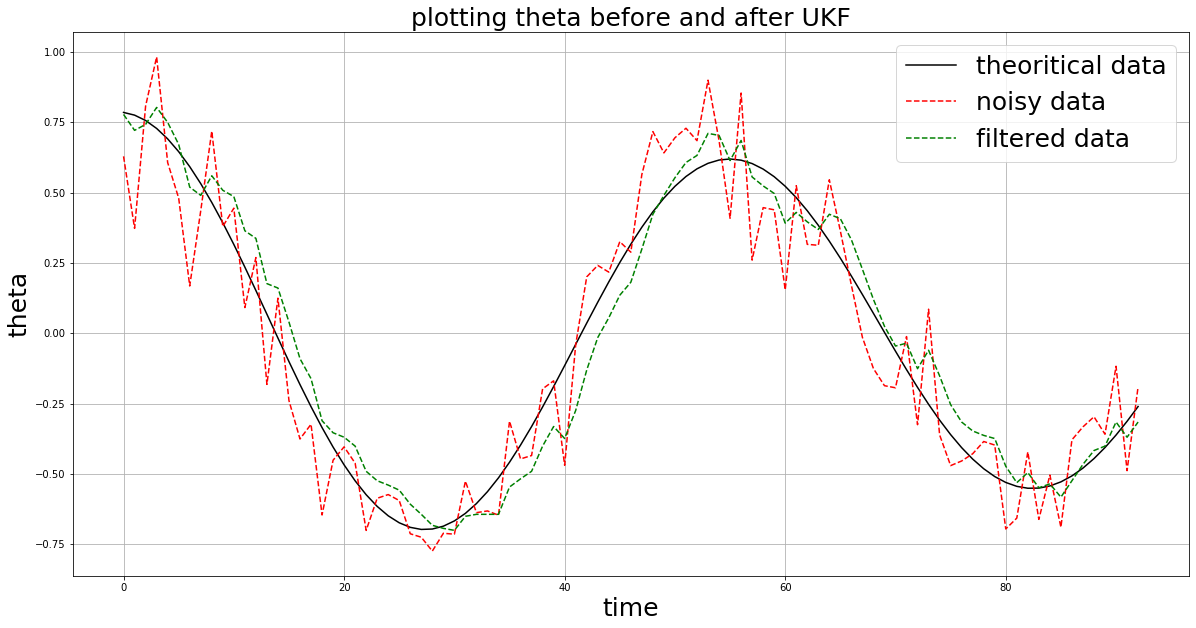

In [10]:
### plotting the behavior of ukf 
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(theta_theoritical,'black',label="theoritical data")
plt.plot(readings_noisy, 'r--',label='noisy data')
plt.plot(readings_after_ukf, 'g--', label="filtered data")
plt.title('plotting theta before and after UKF',fontsize=25)
plt.xlabel('time',fontsize=25)
plt.ylabel('theta',fontsize=25)
plt.legend(fontsize=25)
plt.grid(True)
plt.show()

###this figure is with friction .but without it it will continue it's oscilation 

In [11]:
'''
Simulating the equation $mL^2\ddot{\theta} + b \dot{\theta} +mgL sin(\theta) = 0$
'''
# this cell is to implement UKF with kappa =5


import numpy as np
import cv2
import time

from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import JulierSigmaPoints
import matplotlib.pyplot as plt


# visulaization parameters
height = 600
width = 600

# simulation 
center = None

# Pendulum parameters and variables

#    initial conditions
theta = np.pi/4 # the angle 
omega = 0           # the angular velocity 

#    parametrs
g = 9.8 # m/s^2
L = .2 # m
m = 0.05 # kg
b = 0.001  # friction constant 

# Numerical integration parameters
framerate = 60.0 # in frames per second
dt = 1.0/framerate # Set dt to match the framerate of the webcam or animation
t = time.clock()

# Drawing parametres
thickness = 3

# Noise parameters 
Sigma = 30*np.array([[1, 0],[0,1]])

#Kalman inferred state variables
theta_kf = theta
omega_kf = omega


# Create background image
frame = np.zeros((height,width,3), np.uint8)

center_old = (300, 300)
center_noisy_old = (300, 300)
center_kf_old = (300, 300)


L_kf= 200
# Create background image
frame = np.zeros((height,width,3), np.uint8)

cv2.circle(frame, (300, 300), 10, (0, 255, 255), -1)  

##################
# ukf functions  #
##################
#function to return the nonlinear state transition vatiables (theta, omega)
def fx(X,dt):
    
    theta=X[0]
    omega=X[1]
    
    theta= theta+ omega*dt
    omega = omega - dt*g/L_kf*np.sin(theta) - dt*b/(m*L_kf*L_kf)*omega
    
    return np.c_[theta,omega]


# The update step converts the sigmas into measurement space via the h(x) function, we need to return theta and omega
#[https://share.cocalc.com/share/7557a5ac1c870f1ec8f01271959b16b49df9d087/Kalman-and-Bayesian-Filters-in-Python/10-Unscented-Kalman-Filter.ipynb?viewer=share]

def hx(X):

    return X

points = MerweScaledSigmaPoints(2, alpha=1e-3, beta=2., kappa=5)
#points = JulierSigmaPoints(n=2, kappa=1)


kf = UKF(dim_x=2, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)
kf.x = np.array([theta_kf ,omega_kf]) # initial state

kf.R = Sigma # a measurement noise matrix  
kf.Q = np.diag([4, 4])   # process noise the smae shape as the state variables 2X2  

######################
# end ukf functions  #
######################
readings_noisy= []
readings_after_ukf=[]
theta_theoritical=[]
while True:
    cv2.circle(frame, (300, 300), 10, (0, 255, 255), -1)   
# == Simulation model ==

    # Update state 
    theta = theta + dt*omega
    theta_theoritical.append(theta)
    omega = omega - dt*g/L*np.sin(theta) - dt*b/(m*L*L)*omega 

    # Map the state to a nearby pixel location
    center = np.array((int(300+ 200*np.sin(theta)) ,int(300 + 200*np.cos( theta))) ) 
   
    center_noisy = tuple(center+np.matmul(Sigma,np.random.randn(2)).astype(int))

    # Draw the pendulum
   
    cv2.circle(frame, tuple(center_old), 10, (0, 0, 0), -1)              
    cv2.circle(frame, center_noisy_old, 10, (0, 0, 0), -1)


    cv2.circle(frame, tuple(center), 10, (0, 255, 255), -1)                
    cv2.circle(frame, center_noisy, 10, (0, 0, 255), -1)                  

    center_old = center
    center_noisy_old = center_noisy


####################################################################
#### here starts  the unscented kalman filter implementation       #
####################################################################
    center_noisy_kf=center_noisy
    readings_noisy.append(np.arctan( (center_noisy_kf[0]-300)/(center_noisy_kf[1]-300)))
    print('theoritical theta and omega',theta,omega)
    #unscented kalman filter pridection 
    kf.predict()
    #print('predicted theta and omega',kf.x[0],kf.x[1])
    
    theta_kf=kf.x[0]
    omega_kf=kf.x[1]
    print('predicted theta and omega',theta_kf,omega_kf)
    
    #center noisy kf update   
    # unscented kalman filter updating the state variables 
    kf.update([ (np.arctan( (center_noisy_kf[0]-300)/(center_noisy_kf[1]-300))),0])
     
    
    #print("after updtae",theta_kf)
    #maping the updated theta to the nearest pixels 
    center_kf = np.array((int(300+ L_kf*np.sin(kf.x[0])) ,int(300 + L_kf*np.cos(kf.x[0]))) )
    readings_after_ukf.append(np.arctan( (center_kf[0]-300)/(center_kf[1]-300)))

    ####################################################################
    #### here finishes the unscented kalman filter implementation      #
    ####################################################################

    # Map the state to a nearby pixel location
    
    cv2.circle(frame, tuple(center_kf_old), 10, (0, 0, 0), -1)
    center_kf_old = center_kf
    cv2.circle(frame, tuple(center_kf), 10, (255, 0, 255), -1)

    # show the frame to our screen
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(int(dt*400)) & 0xFF

    #if the 'Esc' key is pressed, stop the loop
    if key == 27:
        break


# Wait with calculating next animation step to match the intended framerate
t_ready = time.clock()
d_t_animation = t + dt -  t_ready
t += dt
if  d_t_animation > 0:
    time.sleep(d_t_animation)






# close all windows
cv2.destroyAllWindows()

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


theoritical theta and omega 0.7853981633974483 -0.5774705379690138
predicted theta and omega 0.7853981633816147 -0.00028865523316312647
theoritical theta and omega 0.7757736544312981 -1.1445442912093784
predicted theta and omega 0.788666495202051 0.000631889284591125
theoritical theta and omega 0.7566979162444751 -1.6956678719863245
predicted theta and omega 0.7819337642140454 0.002235108962281629
theoritical theta and omega 0.7284367850447031 -2.225195534598921
predicted theta and omega 0.8067764326988254 0.004732530194587525
theoritical theta and omega 0.6913501928013878 -2.7273408833628894
predicted theta and omega 0.768705939182837 0.0054938592733719815
theoritical theta and omega 0.6458945114120063 -3.1961753274347235
predicted theta and omega 0.7064493877260247 0.005390364659774605
theoritical theta and omega 0.5926249226214275 -3.625681744286737
predicted theta and omega 0.677348298173456 0.005949320709873973
theoritical theta and omega 0.5321968935499819 -4.009866948692588
pred

theoritical theta and omega -0.4064646841189305 -2.4363014078008036
predicted theta and omega -0.21115368280516122 -0.005538652182053738
theoritical theta and omega -0.4470697075822772 -2.062933400078363
predicted theta and omega -0.3133611605699116 -0.007435756082941225
theoritical theta and omega -0.48145193091691657 -1.667571277721494
predicted theta and omega -0.28857696044360637 -0.005938445481660892
theoritical theta and omega -0.5092447855456081 -1.2555351516625841
predicted theta and omega -0.372218007047195 -0.00757235070977913
theoritical theta and omega -0.5301703714066512 -0.8321000879895063
predicted theta and omega -0.4498420387972146 -0.008905611119189416
theoritical theta and omega -0.5440387062064763 -0.40246266551325743
predicted theta and omega -0.5036161499083391 -0.009542143825228777
theoritical theta and omega -0.5507464172983639 0.028271984925277886
predicted theta and omega -0.5551781226749881 -0.010141529513248315
theoritical theta and omega -0.5502752175496093

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:176: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


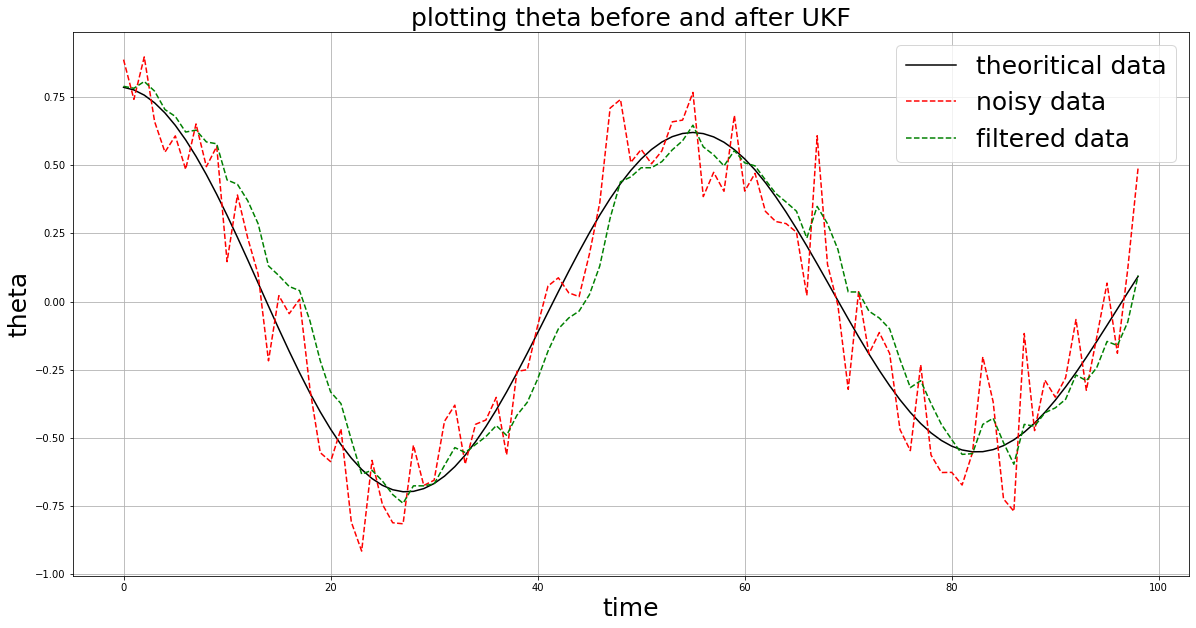

In [14]:
### plotting the behavior of ukf 
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(theta_theoritical,'black',label="theoritical data")
plt.plot(readings_noisy, 'r--',label='noisy data')
plt.plot(readings_after_ukf, 'g--', label="filtered data")
plt.title('plotting theta before and after UKF',fontsize=25)
plt.xlabel('time',fontsize=25)
plt.ylabel('theta',fontsize=25)
plt.legend(fontsize=25)
plt.grid(True)
plt.show()

###this figure is with friction .but without it it will continue it's oscilation 